# Real-Time Sign Language Translator - Data Collection & Preprocessing

This notebook handles data collection, exploration, and preprocessing for the sign language translator.

**Objectives:**
- Capture sign language video data from webcam
- Organize dataset structure
- Implement data preprocessing
- Create data augmentation pipeline
- Prepare training/validation/test splits
- Create PyTorch DataLoader

## 1. Import Libraries and Load Configuration

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import os
import json
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Load configuration
project_root = os.path.abspath('..')
config_file = os.path.join(project_root, 'config.json')

with open(config_file, 'r') as f:
    config = json.load(f)

# Convert string device back to torch.device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config['device'] = device

print("Configuration loaded successfully!")
print(f"Using device: {device}")
print(f"Project root: {project_root}")

Configuration loaded successfully!
Using device: cuda
Project root: d:\Projects\RealTime-Sign-Language-Translator


## 2. Define Sign Language Classes

For this project, we'll start with American Sign Language (ASL) alphabet (A-Z).

In [3]:
# Define ASL alphabet classes
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
           'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
           'U', 'V', 'W', 'X', 'Y', 'Z']

class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print(f"Total classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"\nClass to Index mapping (first 5):")
for i, (cls, idx) in enumerate(list(class_to_idx.items())[:5]):
    print(f"  {cls} -> {idx}")
print("  ...")

# Save class mappings
class_mapping_file = os.path.join(project_root, 'class_mapping.json')
with open(class_mapping_file, 'w') as f:
    json.dump({'class_to_idx': class_to_idx, 'idx_to_class': idx_to_class}, f, indent=4)
    
print(f"\n✓ Class mapping saved to: {class_mapping_file}")

Total classes: 26
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Class to Index mapping (first 5):
  A -> 0
  B -> 1
  C -> 2
  D -> 3
  E -> 4
  ...

✓ Class mapping saved to: d:\Projects\RealTime-Sign-Language-Translator\class_mapping.json


## 3. Data Collection Tool

Create a tool to capture sign language gestures from webcam. This will collect video sequences for each sign.

In [4]:
def collect_sign_data(sign_label, num_sequences=30, sequence_length=30):
    """
    Collect video sequences for a specific sign language gesture.
    
    Args:
        sign_label: The sign to collect (e.g., 'A', 'B', 'C')
        num_sequences: Number of video sequences to collect
        sequence_length: Number of frames per sequence
    """
    # Create directory for this sign
    sign_dir = os.path.join(project_root, 'data', 'raw', sign_label)
    os.makedirs(sign_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(0)
    
    print(f"\nCollecting data for sign: {sign_label}")
    print(f"Total sequences to collect: {num_sequences}")
    print(f"Frames per sequence: {sequence_length}")
    print("\nInstructions:")
    print("1. Press 'SPACE' to start recording a sequence")
    print("2. Make the sign gesture while recording")
    print("3. Press 'q' to quit early")
    print("\nGet ready...")
    
    collected_sequences = 0
    
    while collected_sequences < num_sequences:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Display frame with instructions
        display_frame = frame.copy()
        cv2.putText(display_frame, f"Sign: {sign_label}", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(display_frame, f"Sequences: {collected_sequences}/{num_sequences}", 
                   (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(display_frame, "Press SPACE to record, 'q' to quit", 
                   (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        cv2.imshow('Data Collection', display_frame)
        
        key = cv2.waitKey(1)
        
        # Press space to start recording
        if key == ord(' '):
            # Create sequence directory
            seq_dir = os.path.join(sign_dir, f'seq_{collected_sequences}')
            os.makedirs(seq_dir, exist_ok=True)
            
            # Countdown
            for i in range(3, 0, -1):
                ret, frame = cap.read()
                countdown_frame = frame.copy()
                cv2.putText(countdown_frame, str(i), (250, 250), 
                           cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 255), 5)
                cv2.imshow('Data Collection', countdown_frame)
                cv2.waitKey(1000)
            
            # Record sequence
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                if not ret:
                    break
                    
                # Save frame
                frame_path = os.path.join(seq_dir, f'frame_{frame_num}.jpg')
                cv2.imwrite(frame_path, frame)
                
                # Display recording status
                recording_frame = frame.copy()
                cv2.putText(recording_frame, "RECORDING", (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.putText(recording_frame, f"Frame: {frame_num+1}/{sequence_length}", 
                           (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.imshow('Data Collection', recording_frame)
                cv2.waitKey(1)
            
            collected_sequences += 1
            print(f"✓ Sequence {collected_sequences} collected")
            
            # Short pause
            time.sleep(1)
        
        # Press 'q' to quit
        elif key == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    print(f"\n✓ Data collection complete for sign '{sign_label}'")
    print(f"  Total sequences collected: {collected_sequences}")
    print(f"  Data saved to: {sign_dir}")
    
    return collected_sequences

print("✓ Data collection function defined")
print("\nNote: This function will open your webcam and allow you to collect gesture data.")
print("To use it, call: collect_sign_data('A', num_sequences=5, sequence_length=30)")

✓ Data collection function defined

Note: This function will open your webcam and allow you to collect gesture data.
To use it, call: collect_sign_data('A', num_sequences=5, sequence_length=30)


## 4. Alternative: Download ASL Dataset

Instead of collecting data manually, we can use a pre-existing dataset. Let's download the ASL Alphabet dataset from Kaggle.

In [6]:
# Install kagglehub if not already installed
try:
    import kagglehub
    print("✓ kagglehub already installed")
except:
    !pip install kagglehub
    import kagglehub
    print("✓ kagglehub installed")

# Download ASL Alphabet dataset
print("\nDownloading ASL Alphabet dataset from Kaggle...")
print("This may take a few minutes...")

try:
    # Download latest version
    path = kagglehub.dataset_download("grassknoted/asl-alphabet")
    
    print(f"\n✓ Dataset downloaded successfully!")
    print(f"Path to dataset files: {path}")
    
    # List contents
    import os
    contents = os.listdir(path)
    print(f"\nDataset contents: {contents}")
    
except Exception as e:
    print(f"\n✗ Error downloading dataset: {e}")
    print("\nAlternative: You can manually download the dataset from:")
    print("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")
    print("and extract it to the data/raw folder")

✓ kagglehub already installed

This may take a few minutes...

✓ Dataset downloaded successfully!
Path to dataset files: C:\Users\nasir\.cache\kagglehub\datasets\grassknoted\asl-alphabet\versions\1

Dataset contents: ['asl_alphabet_test', 'asl_alphabet_train']


## 5. Explore Downloaded Dataset

Let's explore the structure and contents of the downloaded dataset.

DATASET EXPLORATION
Training data path: C:\Users\nasir\.cache\kagglehub\datasets\grassknoted\asl-alphabet\versions\1\asl_alphabet_train\asl_alphabet_train

Number of classes: 29
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

Images per class:
  Class  Number of Images
      A              3000
      B              3000
      C              3000
      D              3000
      E              3000
      F              3000
      G              3000
      H              3000
      I              3000
      J              3000
      K              3000
      L              3000
      M              3000
      N              3000
      O              3000
      P              3000
      Q              3000
      R              3000
      S              3000
      T              3000
      U              3000
      V              3000
      W              3000
      X     

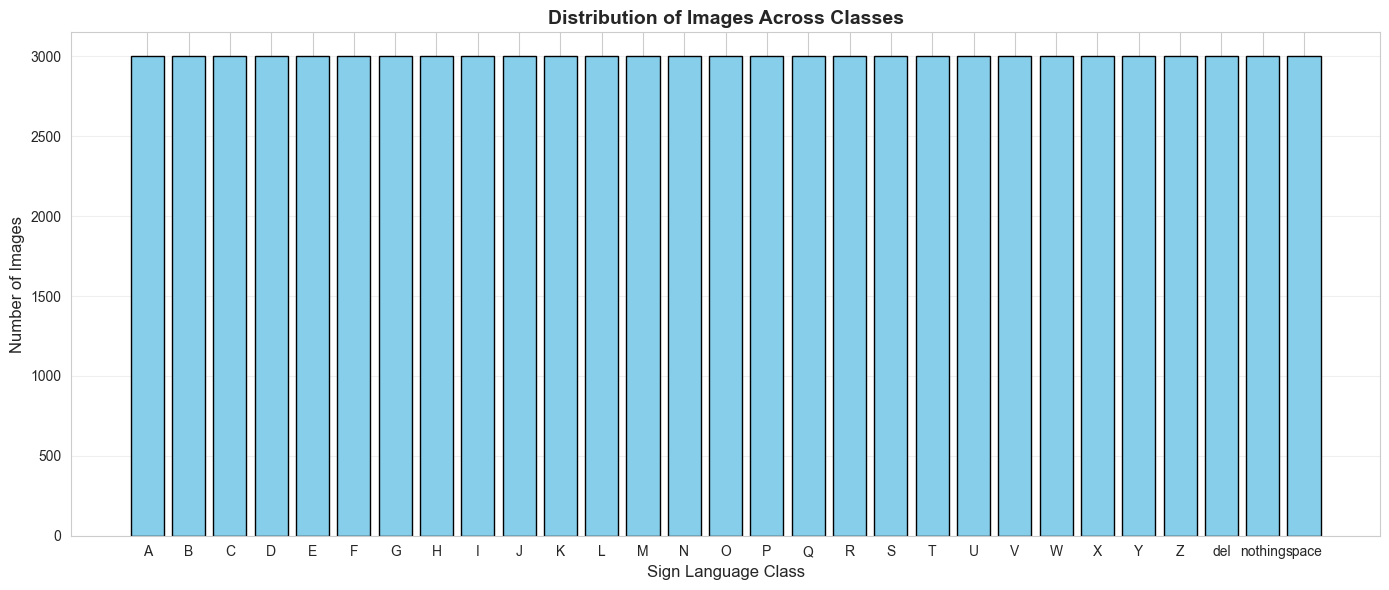

In [7]:
def explore_dataset(dataset_path):
    """Explore the structure and contents of the dataset."""
    
    print("="*60)
    print("DATASET EXPLORATION")
    print("="*60)
    
    # Find asl_alphabet_train folder
    train_path = os.path.join(dataset_path, 'asl_alphabet_train', 'asl_alphabet_train')
    
    if not os.path.exists(train_path):
        # Try alternative path
        train_path = os.path.join(dataset_path, 'asl_alphabet_train')
        
        if not os.path.exists(train_path):
            print("Dataset structure:")
            for root, dirs, files in os.walk(dataset_path):
                level = root.replace(dataset_path, '').count(os.sep)
                indent = ' ' * 2 * level
                print(f'{indent}{os.path.basename(root)}/')
                if level < 2:  # Only show first 2 levels
                    subindent = ' ' * 2 * (level + 1)
                    for d in dirs[:10]:
                        print(f'{subindent}{d}/')
            return None
    
    print(f"Training data path: {train_path}\n")
    
    # Get class folders
    class_folders = sorted([f for f in os.listdir(train_path) 
                           if os.path.isdir(os.path.join(train_path, f))])
    
    print(f"Number of classes: {len(class_folders)}")
    print(f"Classes: {class_folders}\n")
    
    # Count images per class
    class_counts = {}
    for class_name in class_folders:
        class_path = os.path.join(train_path, class_name)
        num_images = len([f for f in os.listdir(class_path) 
                         if f.endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = num_images
    
    # Display statistics
    df = pd.DataFrame(list(class_counts.items()), 
                     columns=['Class', 'Number of Images'])
    df = df.sort_values('Class')
    
    print("Images per class:")
    print(df.to_string(index=False))
    
    print(f"\nTotal images: {df['Number of Images'].sum()}")
    print(f"Average per class: {df['Number of Images'].mean():.0f}")
    print(f"Min per class: {df['Number of Images'].min()}")
    print(f"Max per class: {df['Number of Images'].max()}")
    
    # Visualize distribution
    plt.figure(figsize=(14, 6))
    plt.bar(df['Class'], df['Number of Images'], color='skyblue', edgecolor='black')
    plt.xlabel('Sign Language Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title('Distribution of Images Across Classes', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("="*60)
    
    return train_path

# Explore the dataset
if 'path' in locals():
    train_data_path = explore_dataset(path)
else:
    print("Dataset not downloaded yet. Please run the previous cell first.")

## 6. Visualize Sample Images

Let's visualize some sample images from the dataset.

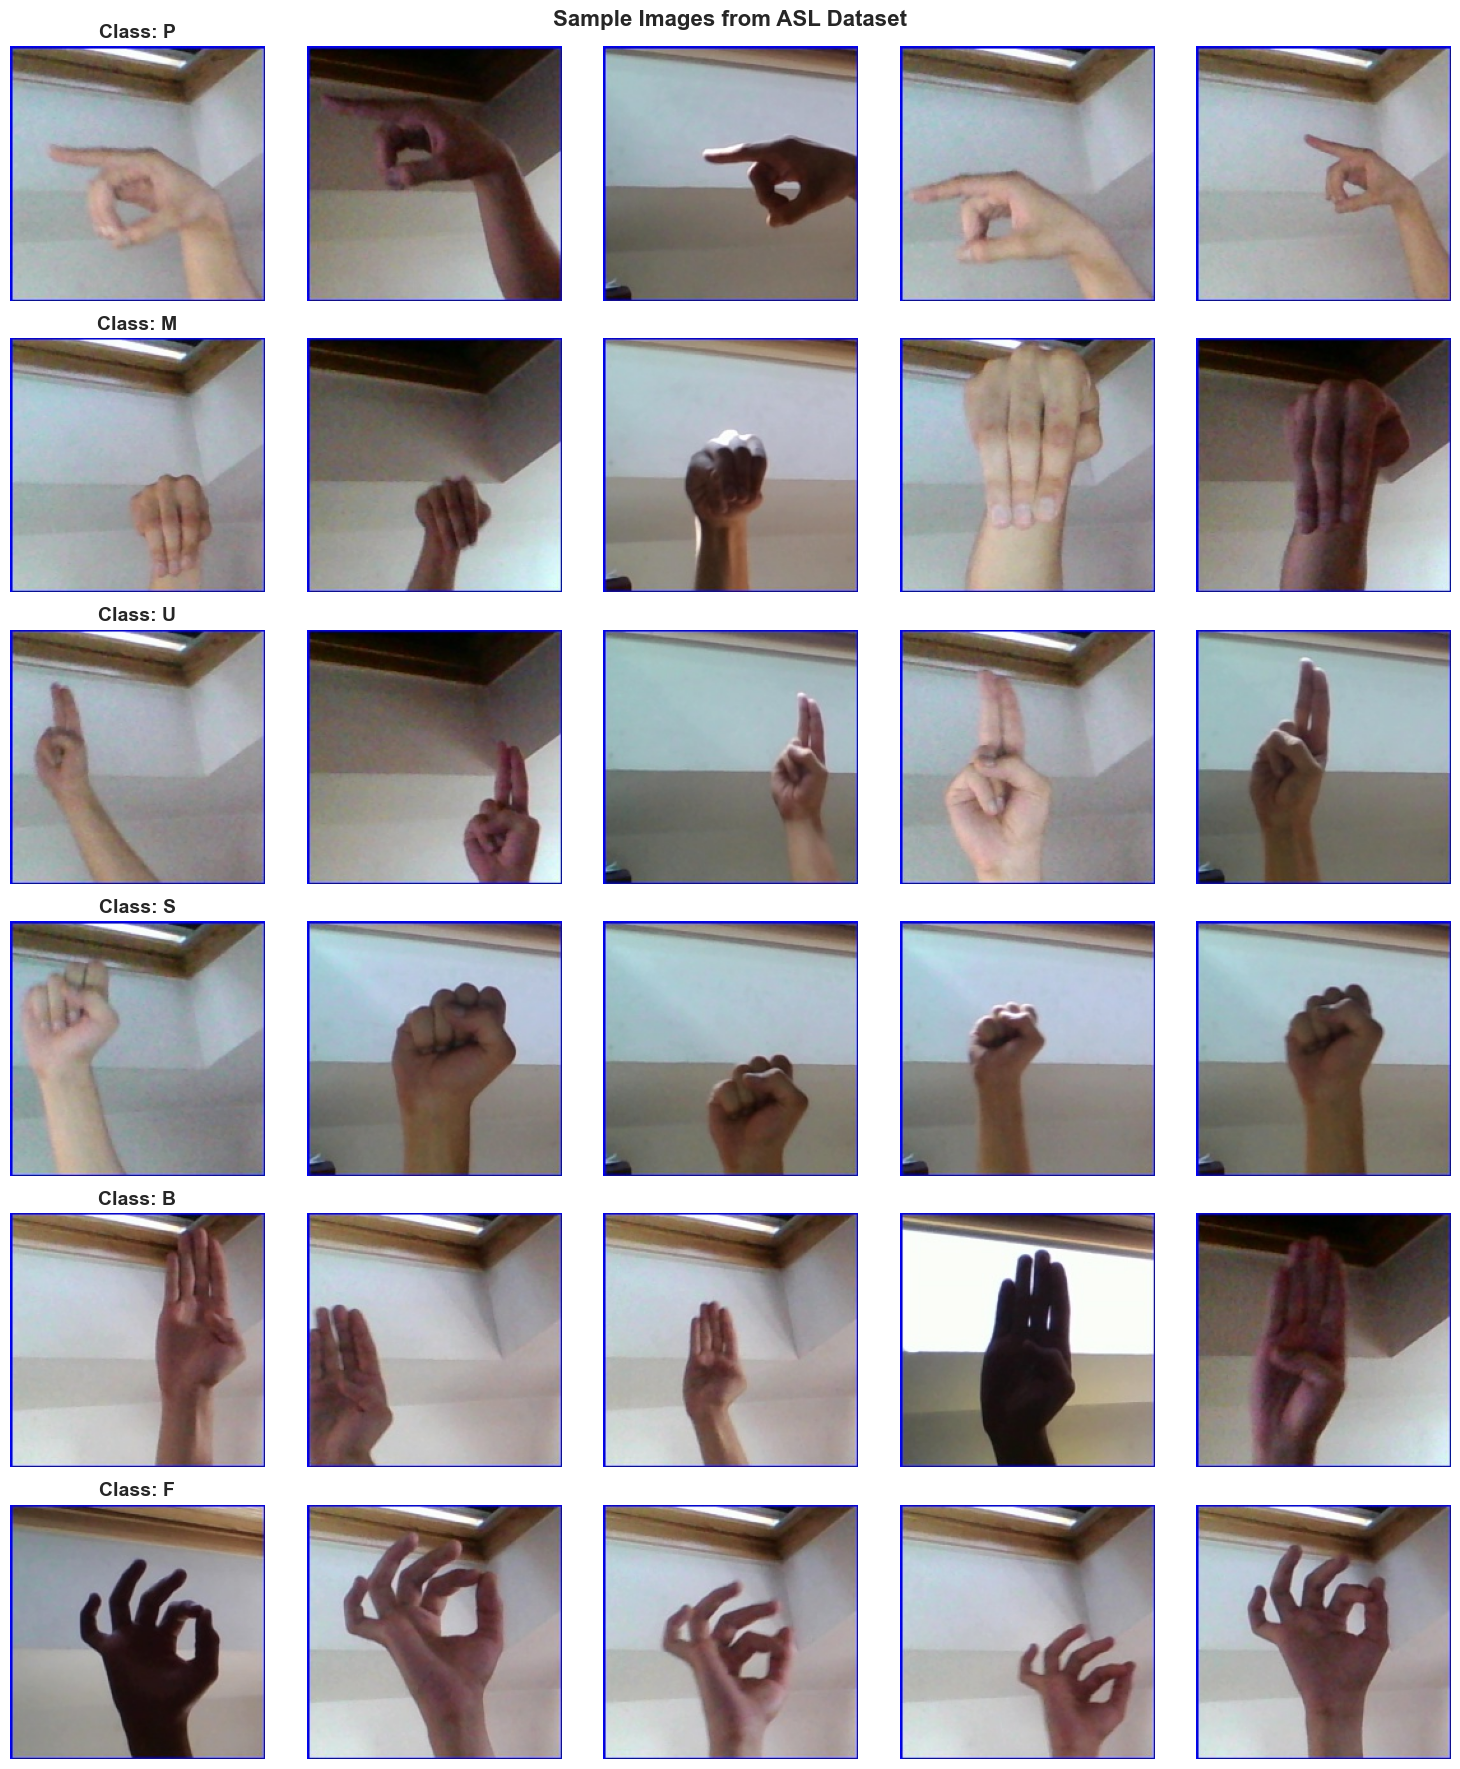

In [8]:
def visualize_samples(train_path, num_samples=5, num_classes=10):
    """Visualize random samples from the dataset."""
    
    if train_path is None or not os.path.exists(train_path):
        print("Train path not found. Please explore dataset first.")
        return
    
    # Get class folders
    class_folders = sorted([f for f in os.listdir(train_path) 
                           if os.path.isdir(os.path.join(train_path, f))])
    
    # Select random classes
    selected_classes = np.random.choice(class_folders, 
                                       min(num_classes, len(class_folders)), 
                                       replace=False)
    
    fig, axes = plt.subplots(num_classes, num_samples, 
                            figsize=(num_samples*3, num_classes*3))
    
    if num_classes == 1:
        axes = axes.reshape(1, -1)
    
    for i, class_name in enumerate(selected_classes):
        class_path = os.path.join(train_path, class_name)
        images = [f for f in os.listdir(class_path) 
                 if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        # Select random images
        selected_images = np.random.choice(images, 
                                          min(num_samples, len(images)), 
                                          replace=False)
        
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            if j == 0:
                axes[i, j].set_title(f'Class: {class_name}', 
                                    fontsize=14, fontweight='bold')
    
    plt.suptitle('Sample Images from ASL Dataset', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Visualize samples
if 'train_data_path' in locals() and train_data_path is not None:
    visualize_samples(train_data_path, num_samples=5, num_classes=6)
else:
    print("Train data path not available. Please explore dataset first.")

## 7. Create Custom Dataset Class

Define a PyTorch Dataset class for loading and preprocessing sign language images.

In [9]:
class SignLanguageDataset(Dataset):
    """Custom Dataset for Sign Language Images."""
    
    def __init__(self, data_path, transform=None, class_to_idx=None):
        """
        Args:
            data_path: Path to the dataset directory
            transform: Optional transform to be applied on images
            class_to_idx: Dictionary mapping class names to indices
        """
        self.data_path = data_path
        self.transform = transform
        self.class_to_idx = class_to_idx
        
        # Get all image paths and labels
        self.images = []
        self.labels = []
        
        if not os.path.exists(data_path):
            raise ValueError(f"Data path does not exist: {data_path}")
        
        # Walk through directory structure
        for class_name in os.listdir(data_path):
            class_path = os.path.join(data_path, class_name)
            
            if not os.path.isdir(class_path):
                continue
            
            # Get class index
            if class_to_idx and class_name in class_to_idx:
                class_idx = class_to_idx[class_name]
            else:
                # Auto-assign index
                class_idx = len(set(self.labels))
            
            # Get all images in this class
            for img_name in os.listdir(class_path):
                if img_name.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)
        
        print(f"Loaded {len(self.images)} images from {len(set(self.labels))} classes")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ SignLanguageDataset class defined")

✓ SignLanguageDataset class defined


## 8. Define Data Augmentation and Preprocessing

Create transforms for data augmentation and normalization.

In [10]:
# Define image transformations

# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

print("✓ Data transforms defined")
print("\nTraining transforms (with augmentation):")
print("  - Resize to 224x224")
print("  - Random rotation (±15°)")
print("  - Random translation (±10%)")
print("  - Color jitter")
print("  - Random horizontal flip")
print("  - Normalization")
print("\nValidation transforms (no augmentation):")
print("  - Resize to 224x224")
print("  - Normalization")

✓ Data transforms defined

Training transforms (with augmentation):
  - Resize to 224x224
  - Random rotation (±15°)
  - Random translation (±10%)
  - Color jitter
  - Random horizontal flip
  - Normalization

Validation transforms (no augmentation):
  - Resize to 224x224
  - Normalization


## 9. Split Dataset and Create DataLoaders

Split the dataset into training, validation, and test sets, then create PyTorch DataLoaders.

In [11]:
from sklearn.model_selection import train_test_split
import shutil

def split_and_organize_dataset(source_path, target_base_path, 
                               train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split dataset into train/val/test and organize into separate folders.
    
    Args:
        source_path: Path to original dataset
        target_base_path: Base path for organized dataset
        train_ratio: Proportion for training set
        val_ratio: Proportion for validation set
        test_ratio: Proportion for test set
    """
    
    if not os.path.exists(source_path):
        print(f"Source path does not exist: {source_path}")
        return None, None, None
    
    print("Splitting and organizing dataset...")
    print(f"Train: {train_ratio*100}%, Val: {val_ratio*100}%, Test: {test_ratio*100}%")
    
    # Create target directories
    splits = ['train', 'val', 'test']
    for split in splits:
        split_path = os.path.join(target_base_path, split)
        os.makedirs(split_path, exist_ok=True)
    
    # Get class folders
    class_folders = sorted([f for f in os.listdir(source_path) 
                           if os.path.isdir(os.path.join(source_path, f))])
    
    split_stats = {split: 0 for split in splits}
    
    for class_name in tqdm(class_folders, desc="Processing classes"):
        class_source = os.path.join(source_path, class_name)
        
        # Get all images
        images = [f for f in os.listdir(class_source) 
                 if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        if len(images) == 0:
            continue
        
        # Split images
        train_imgs, temp_imgs = train_test_split(images, 
                                                 train_size=train_ratio, 
                                                 random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, 
                                               train_size=val_ratio/(val_ratio+test_ratio), 
                                               random_state=42)
        
        # Copy images to respective folders
        for split_name, split_imgs in [('train', train_imgs), 
                                       ('val', val_imgs), 
                                       ('test', test_imgs)]:
            split_class_path = os.path.join(target_base_path, split_name, class_name)
            os.makedirs(split_class_path, exist_ok=True)
            
            for img_name in split_imgs:
                src = os.path.join(class_source, img_name)
                dst = os.path.join(split_class_path, img_name)
                shutil.copy2(src, dst)
            
            split_stats[split_name] += len(split_imgs)
    
    print("\n" + "="*60)
    print("Dataset Split Summary")
    print("="*60)
    for split in splits:
        print(f"{split.capitalize():10s}: {split_stats[split]:6d} images")
    print(f"{'Total':10s}: {sum(split_stats.values()):6d} images")
    print("="*60)
    
    # Return paths
    paths = {
        'train': os.path.join(target_base_path, 'train'),
        'val': os.path.join(target_base_path, 'val'),
        'test': os.path.join(target_base_path, 'test')
    }
    
    return paths['train'], paths['val'], paths['test']

# Only run if dataset is downloaded
if 'train_data_path' in locals() and train_data_path is not None:
    processed_data_path = os.path.join(project_root, 'data', 'processed')
    train_path, val_path, test_path = split_and_organize_dataset(
        train_data_path, 
        processed_data_path,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15
    )
    print(f"\n✓ Dataset organized successfully!")
else:
    print("Dataset not available. Please download and explore dataset first.")

Splitting and organizing dataset...
Train: 70.0%, Val: 15.0%, Test: 15.0%


Processing classes: 100%|██████████| 29/29 [01:07<00:00,  2.32s/it]


Dataset Split Summary
Train     :  60900 images
Val       :  13050 images
Test      :  13050 images
Total     :  87000 images

✓ Dataset organized successfully!


## 10. Create DataLoaders

Now create PyTorch DataLoaders for efficient batch loading during training.

In [12]:
if 'train_path' in locals() and train_path is not None:
    # Create datasets
    print("Creating datasets...")
    train_dataset = SignLanguageDataset(train_path, transform=train_transform, 
                                       class_to_idx=class_to_idx)
    val_dataset = SignLanguageDataset(val_path, transform=val_transform, 
                                     class_to_idx=class_to_idx)
    test_dataset = SignLanguageDataset(test_path, transform=val_transform, 
                                      class_to_idx=class_to_idx)
    
    # Create dataloaders
    print("\nCreating dataloaders...")
    batch_size = int(config['batch_size'])
    num_workers = int(config['num_workers'])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=num_workers, 
                             pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                           shuffle=False, num_workers=num_workers, 
                           pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                            shuffle=False, num_workers=num_workers, 
                            pin_memory=True)
    
    print("\n" + "="*60)
    print("DataLoader Summary")
    print("="*60)
    print(f"Training batches:   {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches:       {len(test_loader)}")
    print(f"Batch size:         {batch_size}")
    print(f"Num workers:        {num_workers}")
    print("="*60)
    
    # Test dataloader
    print("\nTesting dataloader (this may take a moment on first load)...")
    print("Loading first batch...")
    
    # Use a simpler dataloader for testing to avoid worker initialization delays
    test_batch_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                   shuffle=False, num_workers=0)  # No workers for quick test
    
    images, labels = next(iter(test_batch_loader))
    print(f"✓ Batch loaded successfully!")
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Labels dtype: {labels.dtype}")
    print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
    
    del test_batch_loader  # Clean up
    
    print("\n✓ DataLoaders created successfully!")
    
else:
    print("Paths not available. Please run the dataset splitting cell first.")

Creating datasets...
Loaded 60900 images from 26 classes
Loaded 13050 images from 26 classes
Loaded 13050 images from 26 classes

Creating dataloaders...

DataLoader Summary
Training batches:   1904
Validation batches: 408
Test batches:       408
Batch size:         32
Num workers:        4

Testing dataloader (this may take a moment on first load)...
Loading first batch...
✓ Batch loaded successfully!
Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Image dtype: torch.float32
Labels dtype: torch.int64
Image range: [-2.118, 2.640]

✓ DataLoaders created successfully!


## 11. Visualize Augmented Images

Let's visualize how data augmentation affects the images.

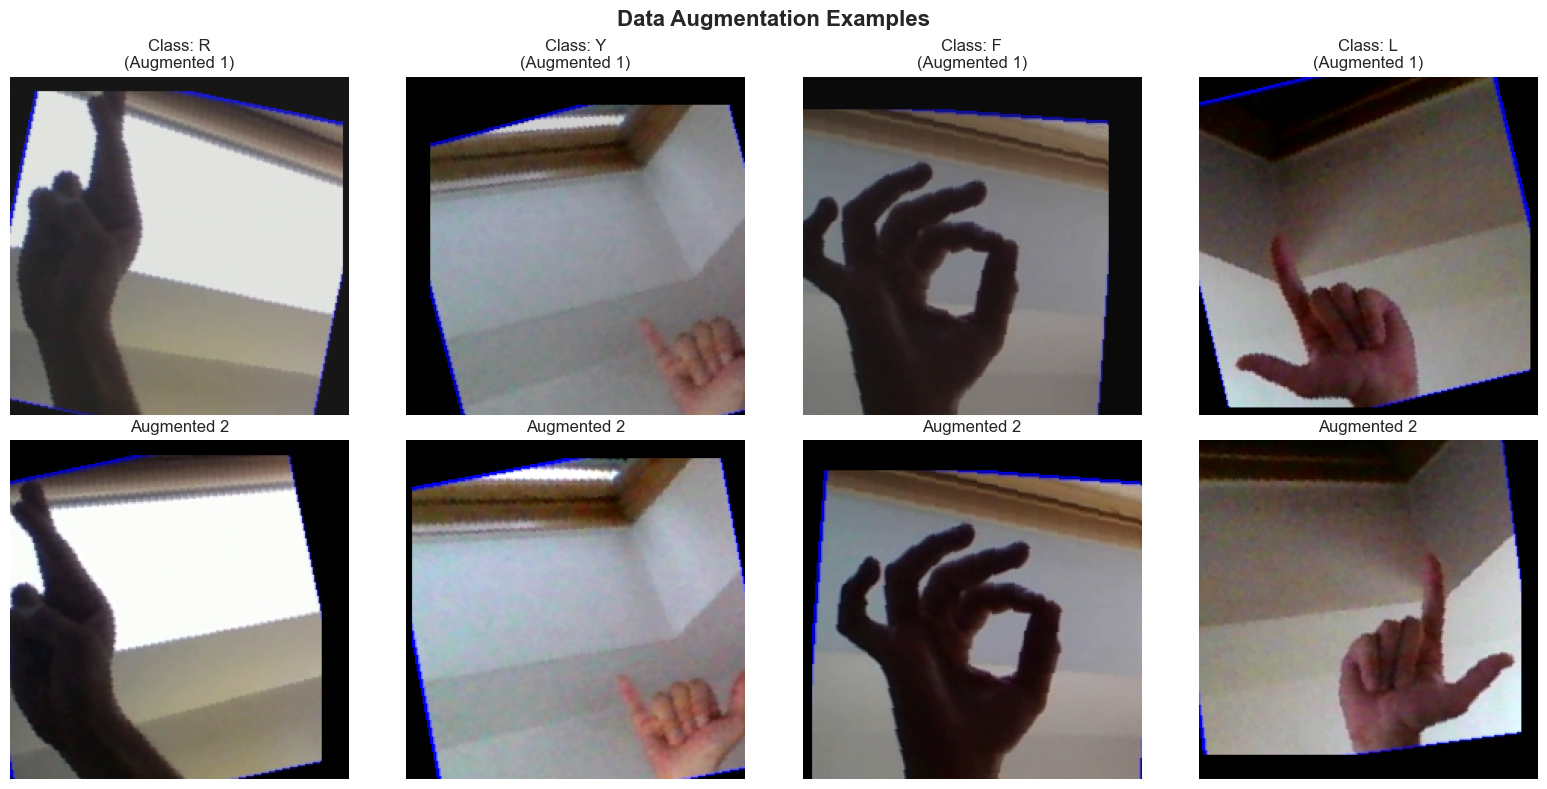

In [13]:
def visualize_augmentations(dataset, num_samples=4):
    """Visualize original and augmented versions of images."""
    
    # Denormalization function
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return tensor * std + mean
    
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*4, 8))
    
    for i in range(num_samples):
        # Get random sample
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        
        # Denormalize
        img_denorm = denormalize(img)
        img_np = img_denorm.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        
        # Get another augmented version
        img2, _ = dataset[idx]
        img2_denorm = denormalize(img2)
        img2_np = img2_denorm.permute(1, 2, 0).numpy()
        img2_np = np.clip(img2_np, 0, 1)
        
        # Get class name
        class_name = idx_to_class[label]
        
        # Plot
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f'Class: {class_name}\n(Augmented 1)', fontsize=12)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(img2_np)
        axes[1, i].set_title('Augmented 2', fontsize=12)
        axes[1, i].axis('off')
    
    plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize augmentations
if 'train_dataset' in locals():
    visualize_augmentations(train_dataset, num_samples=4)
else:
    print("Dataset not created yet. Please run previous cells first.")

## 12. Summary

Data preprocessing and augmentation pipeline is complete!

In [14]:
print("="*60)
print("DATA PREPROCESSING COMPLETE")
print("="*60)

if 'train_loader' in locals():
    print("\n✓ Dataset downloaded and explored")
    print("✓ Custom Dataset class created")
    print("✓ Data augmentation pipeline defined")
    print("✓ Dataset split into train/val/test")
    print("✓ DataLoaders created and tested")
    
    print("\n" + "="*60)
    print("Dataset Statistics")
    print("="*60)
    print(f"Training samples:   {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples:       {len(test_dataset)}")
    print(f"Total samples:      {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
    print(f"Number of classes:  {len(classes)}")
    print(f"Image size:         224x224")
    print(f"Batch size:         {batch_size}")
    print("="*60)
    
    print("\n" + "="*60)
    print("Next Steps")
    print("="*60)
    print("1. Build CNN model architecture")
    print("2. Define training loop")
    print("3. Train the model")
    print("4. Evaluate performance")
    print("5. Implement real-time detection")
    print("="*60)
else:
    print("\nNote: DataLoaders not created. Please ensure:")
    print("1. Dataset is downloaded")
    print("2. Dataset is split and organized")
    print("3. All previous cells are executed")

DATA PREPROCESSING COMPLETE

✓ Dataset downloaded and explored
✓ Custom Dataset class created
✓ Data augmentation pipeline defined
✓ Dataset split into train/val/test
✓ DataLoaders created and tested

Dataset Statistics
Training samples:   60900
Validation samples: 13050
Test samples:       13050
Total samples:      87000
Number of classes:  26
Image size:         224x224
Batch size:         32

Next Steps
1. Build CNN model architecture
2. Define training loop
3. Train the model
4. Evaluate performance
5. Implement real-time detection
